# MLB Baseball Predictions
> Introducing the baseball betting project.

- toc: false
- badges: true
- comments: true
- categories: [baseball, EDA]
- image: images/chart-preview.png

Baseball isn’t associated with good memories for me. I wasn’t very good at it, always hitting foul balls in little league. My parents eventually figured out I needed glasses, but not before I developed a mild disdain for the sport. So it’s with great surprise that I find myself spending so much time thinking about it. Even more so when I make a bet and start cheering for a team. It’s amazing what having some skin in the game will do for your interest level.

This is the first in a blog series, written in jupyter notebooks, which will show you how to build a program that predicts the outcome of MLB games. We'll be using our web scraping and machine learning skills to build a model that outperforms the sports books.

> Warning: Web scraping is dependant on other people's web pages. If they change their site, this blog's code will break. Don't expect the code presented here to work forever.

# Benchmarking the Sportsbooks
First thing to do is figure out how we’re going to know if we’re doing well. The most intuitive performance benchmark I found was the sportsbooks themselves. If I can make better predictions than the sportsbooks, then I should be doing well.

## Downloading Sportsbook Data
We need to start by putting together a database of historic odds and outcomes for MLB games. First step is to get a list of days when games were played. We can get those from [baseball-reference.com](http://baseball-refence.com).

In [9]:
import requests
import re
import datetime as dt
url = 'https://www.baseball-reference.com/leagues/MLB/2019-schedule.shtml'
resp = requests.get(url)
# All the H3 tags contain day names
days = re.findall("<h3>(.*2019)</h3>", resp.text)
dates = [dt.datetime.strptime(d,"%A, %B %d, %Y") for d in days]
print("Number of days MLB was played in 2019:", len(dates))

Number of days MLB was played in 2019: 210


We need the correct days because we'll be pulling the odds data from [covers.com](http://covers.com) by day. Here's how we pull and parse that data.

In [10]:
from bs4 import BeautifulSoup as bs
game_data = []
for d in dates:
    # get the web page with game data on it
    game_day = d.strftime('%Y-%m-%d')
    url = f'https://www.covers.com/Sports/MLB/Matchups?selectedDate={game_day}'
    resp = requests.get(url)

    # parse the games
    scraped_games = bs(resp.text).findAll('div',{'class':'cmg_matchup_game_box'})
    for g in scraped_games:
        game = {}
        game['home_moneyline'] = g['data-game-odd']
        game['away_team_abbr'] = g['data-away-team-shortname-search']
        game['date'] = g['data-game-date']
        game['home_team_abbr'] = g['data-home-team-shortname-search']
        try:
            game['home_score'] =g.find('div',{'class':'cmg_matchup_list_score_home'}).text.strip()
            game['away_score'] =g.find('div',{'class':'cmg_matchup_list_score_away'}).text.strip()
        except:
            game['home_score'] =''
            game['away_score'] =''

        game_data.append(game)
        if len(game_data) % 500==0:
            #show progress
            print(dt.datetime.now(), game_day, len(game_data))
print("Done! Games downloaded:", len(game_data))

2020-09-19 22:14:58.829986 2019-05-02 500
2020-09-19 22:15:26.848715 2019-06-08 1000
2020-09-19 22:15:54.144147 2019-07-18 1500
2020-09-19 22:16:23.091523 2019-08-24 2000
2020-09-19 22:16:53.807905 2019-10-03 2500
Done! Games downloaded: 2533


## Sportsbook Accuracy
Let's see how the sportsbook did in all these games we just downloaded.

In [11]:
from sklearn.metrics import accuracy_score
outcomes = []
predictions = []
probabilities = []

for d in game_data:
    try:
        moneyline = int(d['home_moneyline'])
        home_score = int(d['home_score'])
        away_score = int(d['away_score'])
    except:
        #incomplete data
        continue
    if moneyline==100:
        # it's rare to have a tossup since covers is averaging the odds from several sports books
        # but we'll exclude them from our calculations
        continue
    # convert moneyline odds ot their implied pprobabilities
    # https://www.bettingexpert.com/academy/advanced-betting-theory/odds-conversion-to-percentage
    elif moneyline<0:
        probabilities.append(-moneyline/(-moneyline + 100))
    elif moneyline>0:
        probabilities.append(100/(moneyline + 100))

    outcomes.append(home_score>away_score)
    predictions.append(moneyline<0)

print("Sportsbook accuracy (excluding tossups):", 100*accuracy_score(outcomes,predictions))

Sportsbook accuracy (excluding tossups): 60.05843071786311


That's it, right? We need a model that is better than 60% accurate.

It's not so simple if you plan to use this data for betting. If we really want to make money, we would like to know if we think the odds of a team winning are better or worse that what the sportsbook thinks they are. Then we'd be able to use some sort of [expected value calculation](https://en.wikipedia.org/wiki/Expected_value) to determine if the bet is profitable.

## Sportsbook Calibration
We really want to know if we can build a model that is better [calibrated](https://en.wikipedia.org/wiki/Calibration_(statistics)) than the casino's sportsbooks. High calibration will help us with bet sizing, as well as more sophisticated betting algorithms.

Accuracy: 0.6005843071786311
Brier Loss: 0.39941569282136896


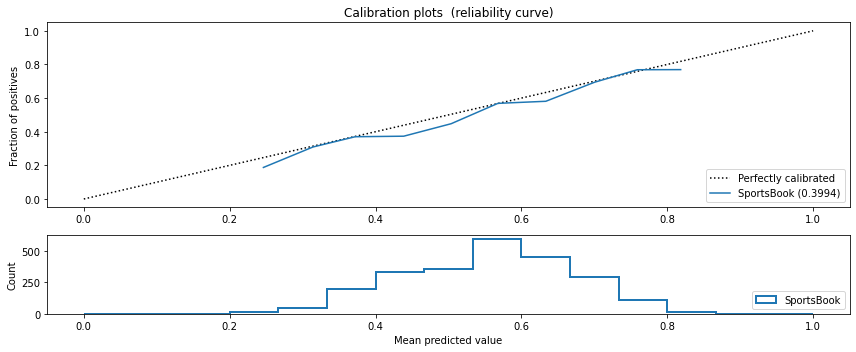

In [12]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, brier_score_loss
import matplotlib.pyplot as plt

def cal_curve(data, bins):
    # adapted from:
    #https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    fig = plt.figure(1, figsize=(12, 5))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for y_test, y_pred, y_proba, name in data:
        brier = brier_score_loss(y_test, y_pred)
        print("Accuracy:",accuracy_score(y_test, y_pred))
        print("Brier Loss:",brier)
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, y_proba, n_bins=bins)
        ax1.plot(mean_predicted_value, fraction_of_positives,
                 label="%s (%1.4f)" % (name, brier))
        ax2.hist(y_proba, range=(0, 1), bins=bins, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()





data = [
    (outcomes, predictions, probabilities, 'SportsBook')
]
cal_curve(data, 15)

The graph above tells us several things about the calibration of the casino's predictions. The reliability curve clearly shows that if the casino says the home team has a 40% chance of winning, over the course of the season very near 40% of those teams will win. The histogram below shows what portion of the games fall into each bucket.

A metric well suited for calibration measurement is the [Brier Score](https://en.wikipedia.org/wiki/Brier_score), which I'll be using to measure the model effectiveness going forward. Beating 0.399 is the target.

# Next Up
Next, we'll start building out our historic data and training the model using XGBoost and LightGBM.
